# Examen a casa de gerente de Ciencia de Datos

#### Estrategia de Clientes

##### Banco Azteca

### Max B. Austria Salazar

Se quiere construir un modelo predictivo para la variable de interés y a partir de las variables $X_1$ a $X_7$.
La variable y es categórica y solo toma los valores $1$ o $0$.

**Paquetes**

In [31]:
#Para las gráficas
library(dplyr)
library(ggplot2)
library(ggfortify)
library(ranger)
library(ggpubr)
library(lattice)

#Para el análisis
library(neuralnet)
library(caret)

**Cargando los datos**

In [2]:
datos <- readr::read_csv(file = "datos.csv")
datos$y <- as.factor(datos$y)
datos$x6 <- as.factor(datos$x6)
datos$x7 <- as.factor(datos$x7)

#Ejemplo
head(datos)

Rows: 20000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): x6, x7
dbl (6): y, x1, x2, x3, x4, x5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


y,x1,x2,x3,x4,x5,x6,x7
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
0,5.954091,-1.650964,0.5588647,-1.0433386,0.52841523,R,B
1,0.940958,-1.760364,0.9339681,1.6705579,0.46626268,R,C
1,-3.560725,-2.529465,1.3213174,-2.6440811,0.47359296,R,C
0,6.664147,-2.770251,0.3818004,3.2893560,0.11103555,R,B
1,-2.069928,-1.972304,0.9215758,1.4597574,0.01373416,R,A
1,5.952991,-2.095696,1.5084816,0.8153361,0.21348338,R,D


## 1) Realiza un análisis exploratorio de datos

Las siguientes son estadísticas descriptivas basicas de las variables:

In [3]:
summary(datos)

 y               x1                 x2                x3         
 0:12703   Min.   :-13.7000   Min.   :-3.6037   Min.   :0.01699  
 1: 7297   1st Qu.:  0.2112   1st Qu.:-2.2677   1st Qu.:0.42701  
           Median :  2.9040   Median :-2.0019   Median :0.66747  
           Mean   :  2.9092   Mean   :-1.9995   Mean   :0.74726  
           3rd Qu.:  5.6042   3rd Qu.:-1.7319   3rd Qu.:0.97690  
           Max.   : 19.1886   Max.   :-0.2788   Max.   :4.39945  
       x4                  x5             x6        x7      
 Min.   :-5.494687   Min.   :0.0000125   AA: 4029   A: 544  
 1st Qu.:-0.797362   1st Qu.:0.0902091   R :15971   B:3797  
 Median :-0.007878   Median :0.2034818              C:8844  
 Mean   : 0.000814   Mean   :0.2472578              D:6815  
 3rd Qu.: 0.820885   3rd Qu.:0.3672842                      
 Max.   : 4.774762   Max.   :0.9808678                      

De lo anterior se puede intuir que:

- Aproximadamente $\frac{1}{3}$ de las observaciones contiene $Y = 1$.
- La media y la mediana de las variables númericas son muy similares, posiblemente sean variables simetricas.
- Los valores de los cuartiles de $X_1$, $X_2$ y $X_4$ paracen ser simétricos.
- Aproximadamente $\frac{1}{4}$ de las observaciones contiene $X_6 = AA$.
- $X_7$ tiene pocas observaciones donde tome el valor $A$.

In [4]:
cor(datos[,-c(1,7,8)])

,x1,x2,x3,x4,x5
x1,1.0000000000,-0.011438164,-0.014931037,-0.0006488473,0.001703013
x2,-0.0114381639,1.000000000,0.005102486,-0.0043831293,-0.003758389
x3,-0.0149310369,0.005102486,1.000000000,0.0136775720,0.002280336
x4,-0.0006488473,-0.004383129,0.013677572,1.0000000000,-0.004031850
x5,0.0017030130,-0.003758389,0.002280336,-0.0040318496,1.000000000


Las variables númericas tienen una correlación muy pequeña, prácticamente nula.

Ahora unas gráficas para mostrar la relación $Y \sim X_i \quad i = 1, \dots, 7$.

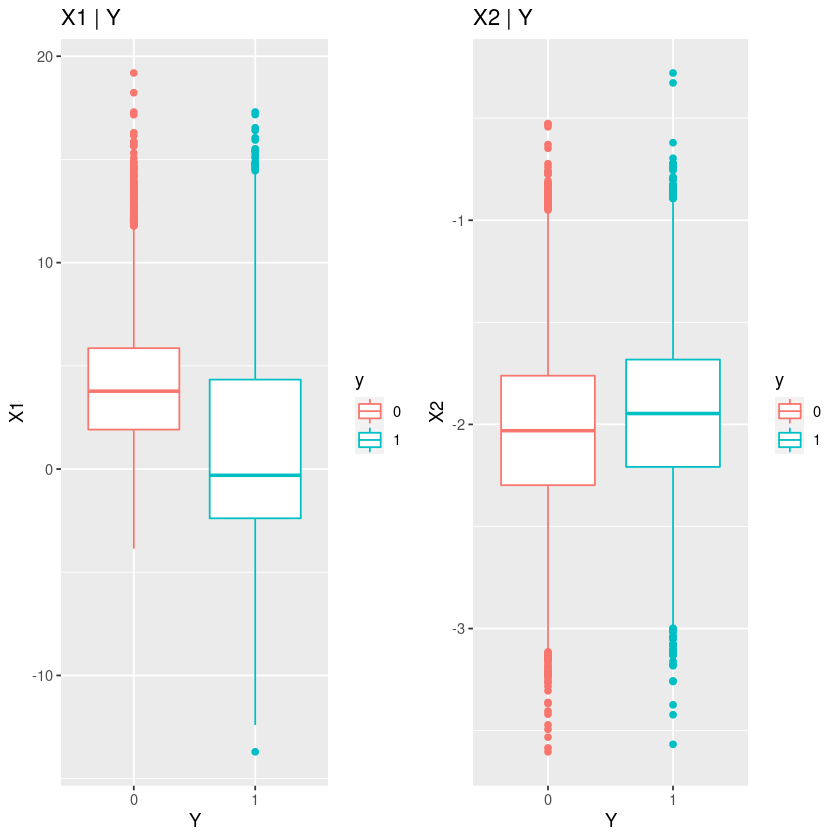

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

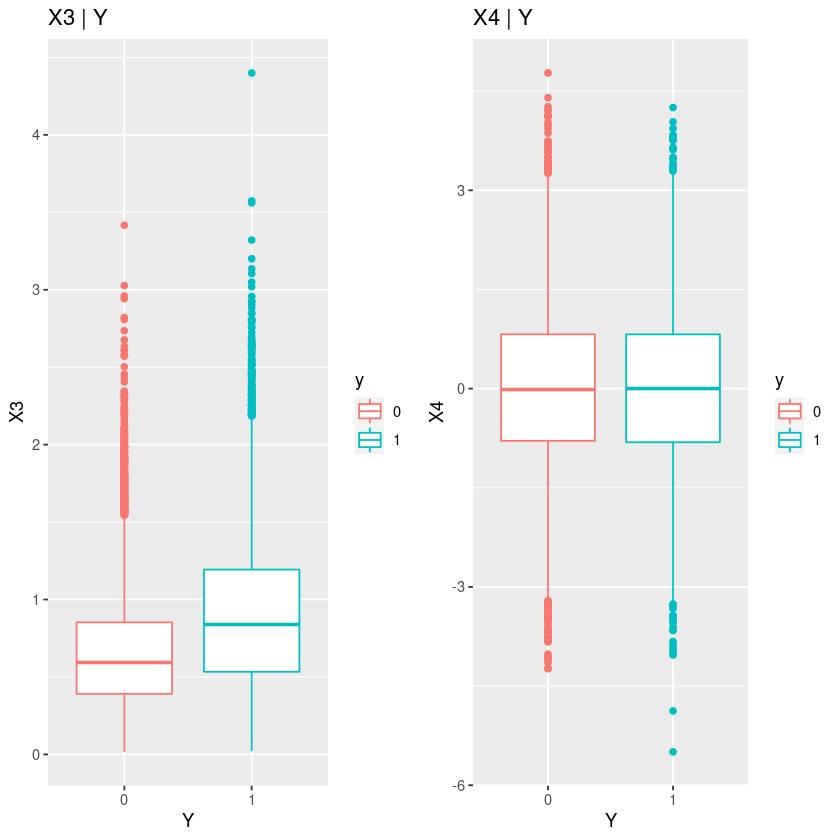

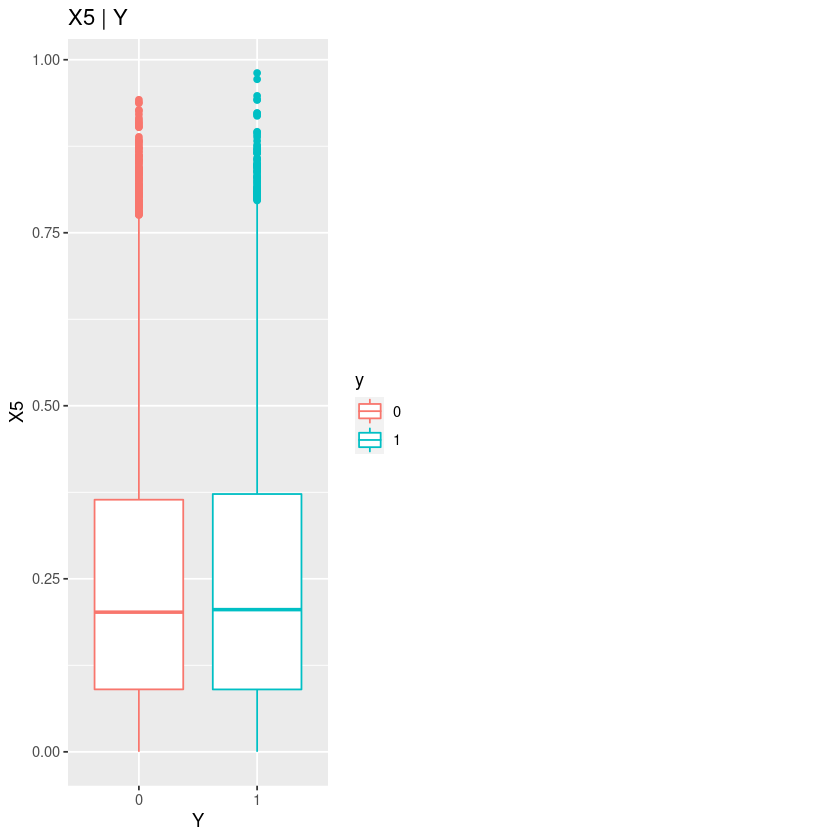

In [5]:
img1 = ggplot(datos, aes(x = y, y = x1, color = y)) + geom_boxplot()+ labs(title = "X1 | Y", y= "X1", x = "Y")
img2 = ggplot(datos, aes(x = y, y = x2, color = y)) + geom_boxplot()+ labs(title = "X2 | Y", y= "X2", x = "Y")
img3 = ggplot(datos, aes(x = y, y = x3, color = y)) + geom_boxplot()+ labs(title = "X3 | Y", y= "X3", x = "Y")
img4 = ggplot(datos, aes(x = y, y = x4, color = y)) + geom_boxplot()+ labs(title = "X4 | Y", y= "X4", x = "Y")
img5 = ggplot(datos, aes(x = y, y = x5, color = y)) + geom_boxplot()+ labs(title = "X5 | Y", y= "X5", x = "Y")

#Gráficando box-plots
options(repr.plot.width = 7, repr.plot.height = 7, plot.width = 7, repr.plot.height = 7)
ggarrange(img1,img2, img3, img4, img5, ncol = 2)

- Las distribuciones que más cambian al ser condicionadas por $Y$ son $X_1$ y $X_3$.
- No se aprecia un cambio importante, en la forma de las gráficas, para el resto de variables.

In [6]:
#Relación entre Y y X_7
print("Frecuencia de X6, condicionada a Y == 0")
fil = which(datos$y == 0)
prop.table(table(datos$x6[fil]))

print("Frecuencia de X6, condicionada a Y == 1")
fil = which(datos$y == 1)
prop.table(table(datos$x6[fil]))

[1] "Frecuencia de X6, condicionada a Y == 0"



       AA         R 
0.2005825 0.7994175 

[1] "Frecuencia de X6, condicionada a Y == 1"



       AA         R 
0.2029601 0.7970399 

- La distribución de $X_6$ parece ser independiente de $Y$.

In [7]:
#Relación entre Y y X_7
print("Frecuencia de X7, condicionada a Y == 0")
fil = which(datos$y == 0)
prop.table(table(datos$x7[fil]))

print("Frecuencia de X7, condicionada a Y == 1")
fil = which(datos$y == 1)
prop.table(table(datos$x7[fil]))

[1] "Frecuencia de X7, condicionada a Y == 0"



         A          B          C          D 
0.02818232 0.19499331 0.43430686 0.34251752 

[1] "Frecuencia de X7, condicionada a Y == 1"



         A          B          C          D 
0.02548993 0.18089626 0.45594080 0.33767302 

- La distribución de $X_7$ parece ser independiente de $Y$.

Como las variables más relevantes son $X_1$ y $X_3$, tomandolas podemos visualizar la separabilidad de las observaciones (de acuerdo con el valor de $Y$):

- Y parece no ser linealmente separable en terminos de $X_1$ y $X_3$.

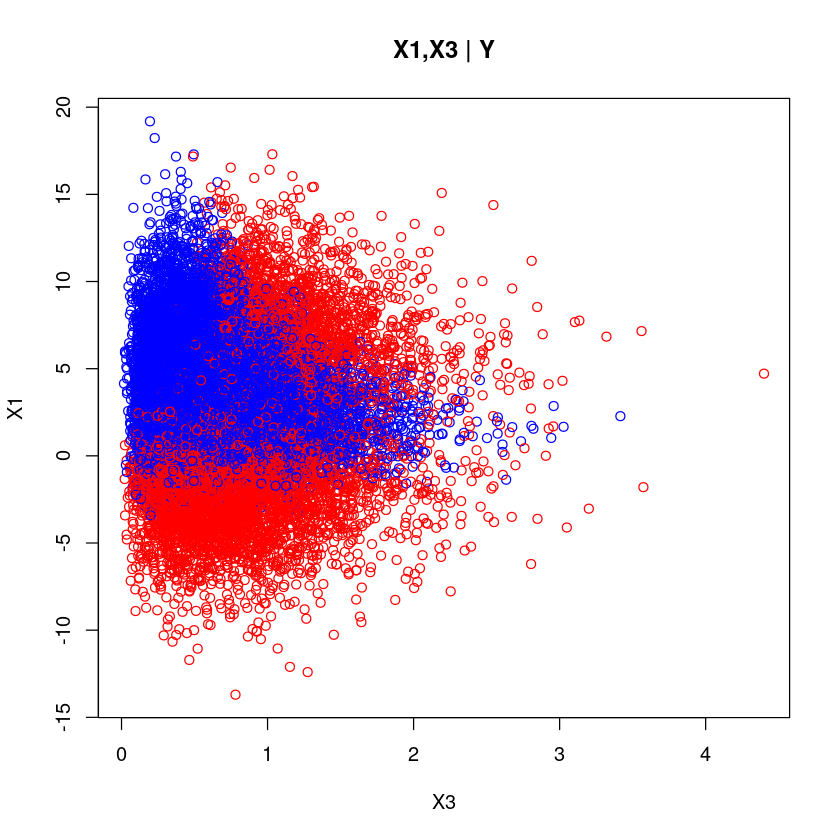

In [8]:
colores = sapply(datos$y,function(y){if(y==0){"blue"}else{"red"}})
plot(x1~ x3, data = datos, col = colores, main = "X1,X3 | Y", xlab = "X3", ylab = "X1")

Una transformación de las variables explicativas puede ayudar a separar el espacio.

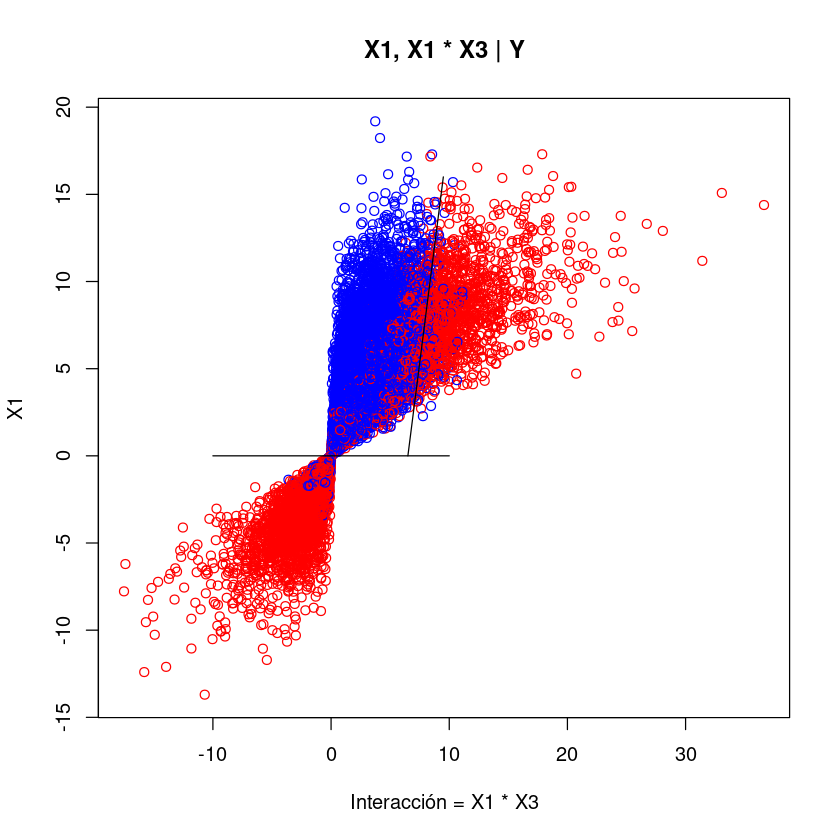

In [9]:
plot(x1~ I(x1*x3),
     data = datos, 
     col = colores,
     main = "X1, X1 * X3 | Y",
     xlab = "Interacción = X1 * X3",
     ylab = "X1")
lines(x = c(6.5,9.5), y = c(0,16), type = "l")
lines(x = c(-10,10), y = c(0,0), type = "l")

De la gráfica anterior se podrían proponer dos reglas para separar el espacio como:
- $X_1 < 0$.
- $X_1 < aX_1*X_3 + b$.

## Modelado

Para separar modelar la variable respuesta elegí dos modelos:

- Regresión logistica.
- Una red neuronal multicapa.


**Separando la muestra**

In [10]:
#Fijando la semilla de números aleatorios
set.seed(0)
#ordenando la muestra de forma aleatoria
muestra = order(runif(dim(datos)[1]))

#separando la muestra
train = muestra[1:10000]
test = muestra[10001:15000]
val = muestra[15001:20000]

### Regresión logistica

Se ajustarán dos regresiones logisticas, una sencilla y otra mas compleja y se mostrará que en este caso, la regresión logistica compleja no es senciblemente mejor que la sencilla.

In [11]:
reg1 = glm(y ~
           + I(x1 < (5.3 * (x1*x3) - 34.6))
           + I(x1<0),
           data = datos[train,], 
           family= "binomial")
summary(reg1) 


Call:
glm(formula = y ~ +I(x1 < (5.3 * (x1 * x3) - 34.6)) + I(x1 < 
    0), family = "binomial", data = datos[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0772  -0.5916  -0.5916   0.6171   1.9127  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -1.65430    0.03248  -50.93   <2e-16 ***
I(x1 < (5.3 * (x1 * x3) - 34.6))TRUE  3.68892    0.12546   29.40   <2e-16 ***
I(x1 < 0)TRUE                         3.21600    0.06393   50.30   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13091.2  on 9999  degrees of freedom
Residual deviance:  8796.3  on 9997  degrees of freedom
AIC: 8802.3

Number of Fisher Scoring iterations: 4


In [12]:
reg2 = glm(y ~ 
             x1:x2
           + x1:x3 
           + I(x1 < (5.3 * (x1*x3) - 34.6))
           + I(x1<0)
           + x2 
           + I(x7 == "C"),
           data = datos[train,], 
           family= "binomial")
summary(reg2) 


Call:
glm(formula = y ~ x1:x2 + x1:x3 + I(x1 < (5.3 * (x1 * x3) - 34.6)) + 
    I(x1 < 0) + x2 + I(x7 == "C"), family = "binomial", data = datos[train, 
    ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1250  -0.6259  -0.2982   0.5280   3.0869  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -0.04112    0.15075  -0.273  0.78505    
I(x1 < (5.3 * (x1 * x3) - 34.6))TRUE  3.75998    0.19390  19.391  < 2e-16 ***
I(x1 < 0)TRUE                         2.10804    0.09680  21.777  < 2e-16 ***
x2                                    0.47883    0.07489   6.393 1.62e-10 ***
I(x7 == "C")TRUE                      0.17930    0.05791   3.096  0.00196 ** 
x1:x2                                 0.27491    0.01139  24.143  < 2e-16 ***
x1:x3                                 0.42398    0.02146  19.758  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parame

**Matrices de confusión**

Primero se evaluaran las matrices de confunsión con los datos de entrenamiento y después con los de validación.

In [13]:
Y1Adj = as.numeric(reg1$fitted.values >= 0.5)
Y1 = datos$y[train]
prop.table(table(as.data.frame(cbind(Y1,Y1Adj))))

   Y1Adj
Y1       0      1
  1 0.5904 0.0476
  2 0.1129 0.2491

In [14]:
Y2Adj = as.numeric(reg2$fitted.values >= 0.5)
#Y1 = datos$y[train]
prop.table(table(as.data.frame(cbind(Y1,Y2Adj))))

   Y2Adj
Y1       0      1
  1 0.5895 0.0485
  2 0.1120 0.2500

En los datos de entrenamiento ambos modelos ajustan correctamente al menos el $80\%$ de las observaciones, pero no se observa que un modelo se senciblemente superior al otro.

In [15]:
Y2 = datos$y[test]
Y1Adj = as.numeric(predict(reg1,data=datos[test, ], type = "response")>=0.5)
prop.table(table(as.data.frame(cbind(Y2,Y1Adj))))

   Y1Adj
Y2       0      1
  1 0.4427 0.1859
  2 0.2606 0.1108

In [16]:
#Y2 = datos$y[test]
Y2Adj = as.numeric(predict(reg2,data=datos[test, ], type = "response")>=0.5)
prop.table(table(as.data.frame(cbind(Y2,Y2Adj))))

   Y2Adj
Y2       0      1
  1 0.4419 0.1867
  2 0.2596 0.1118

En los datos de validación, el ajuste cae notablemente al $55\%$ (aproximadamente). Pero tampoco se observa la superioridad de alguno de los dos.

### Red neuronal multicapa

Se construirá una red multicapa con las mismas variables de las regresiones logisticas.

In [17]:
datos$C <- as.numeric(datos$x7 == "C")

In [18]:
head(datos)

y,x1,x2,x3,x4,x5,x6,x7,C
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
0,5.954091,-1.650964,0.5588647,-1.0433386,0.52841523,R,B,0
1,0.940958,-1.760364,0.9339681,1.6705579,0.46626268,R,C,1
1,-3.560725,-2.529465,1.3213174,-2.6440811,0.47359296,R,C,1
0,6.664147,-2.770251,0.3818004,3.2893560,0.11103555,R,B,0
1,-2.069928,-1.972304,0.9215758,1.4597574,0.01373416,R,A,0
1,5.952991,-2.095696,1.5084816,0.8153361,0.21348338,R,D,0


In [19]:
#Escalando las variables explicativas
trainX <- scale(datos[train,-c(1,5:8)])
testX <- scale(datos[test,-c(1,5:8)],
              center = attr(trainX, "scaled:center"),
              scale = attr(trainX, "scaled:scale"))
valX <- scale(datos[val,-c(1,5:8)],
              center = attr(trainX, "scaled:center"),
              scale = attr(trainX, "scaled:scale"))

trainX <- as.data.frame(trainX)
testX <- as.data.frame(testX)
valX <- as.data.frame(valX)

trainX$y <- datos$y[train]
testX$y <- datos$y[test]
valX$y <- datos$y[val]

Arquitectura de la red.

In [20]:
set.seed(1)
nn = neuralnet(y~.,data = testX, hidden = c(5,3,2,1), linear.output = FALSE, threshold = 0.1)

Matrices de confusión de la red neuronal.

In [28]:
ypred = neuralnet::compute(nn,testX)
prop.table(table(as.data.frame(cbind(as.numeric(testX$y)>1,as.integer(ypred$net.result[,2]>0.5)))))

   V2
V1       0      1
  0 0.5770 0.0516
  1 0.0910 0.2804

In [29]:
ypred = neuralnet::compute(nn,trainX)
prop.table(table(as.data.frame(cbind(as.numeric(trainX$y)>1,as.integer(ypred$net.result[,2]>0.5)))))

   V2
V1       0      1
  0 0.5835 0.0545
  1 0.0944 0.2676

In [30]:
ypred = neuralnet::compute(nn,valX)
prop.table(table(as.data.frame(cbind(as.numeric(valX$y)>1,as.integer(ypred$net.result[,2]>0.5)))))

   V2
V1       0      1
  0 0.5836 0.0524
  1 0.0916 0.2724

## Conclusiones

##### 2) ¿Qué modelo escogerías para poner en producción? ¿Por qué lo harías?

Elegiría la red neuronal pues ofrece un menor número de errores, tanto en el caso de los falsos positivos como en el caso de los falsos negativos. 

##### 3) Si se te dijera que es preferible equivocarse en la clase 0 que en la clase 1, ¿tu decisión de la pregunta anterior sería la misma?

En este caso, mi respuesta seguiria siendo la misma, pues la red es mejor en todas las entradas de todas las matrices de confusión. Pero, en general, si se prefiere un tipo de error sobre otro, se puede trabajar con un threshold diferente a $0.5$ (es decir, se adecua de acuerdo a la preferencia).

